In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy import signal

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [3]:
fish = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_1_AM.csv")

In [4]:
R, L, Z = divide_data_by_flow_direction(fish)
L0, LC1, LC10, LC20, LC30, LC50, LC70, LC100 = divide_data_by_contrast(L)
R0, RC1, RC10, RC20, RC30, RC50, RC70, RC100 = divide_data_by_contrast(R)

In [5]:
for flow in ['L','R']:
    for c in ['1','10','20','30','50','70','100']:
        exec(f'{flow}C{c} = omr_preprocess({flow}C{c})')

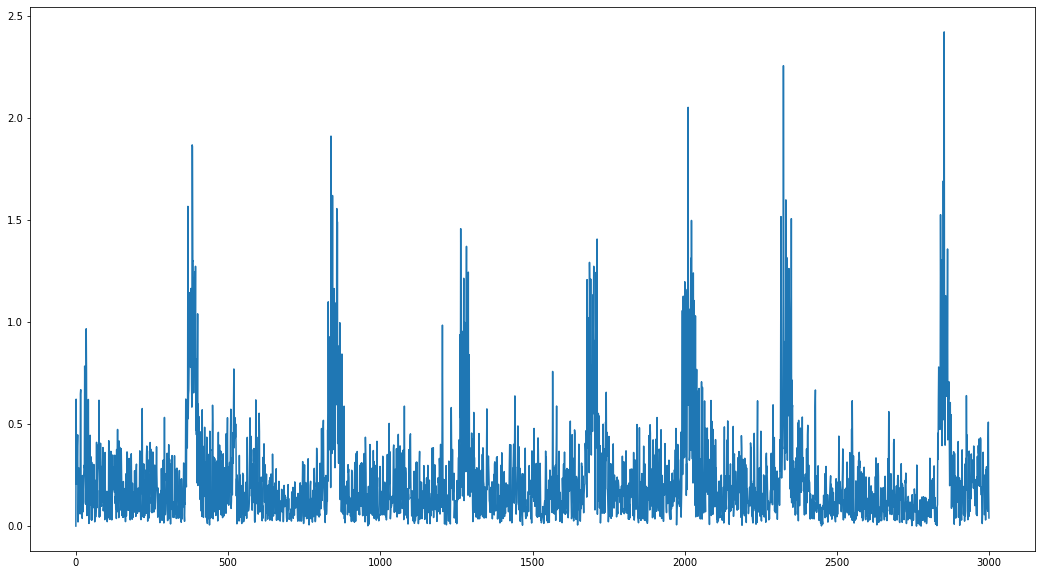

In [6]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(LC20[:,5])

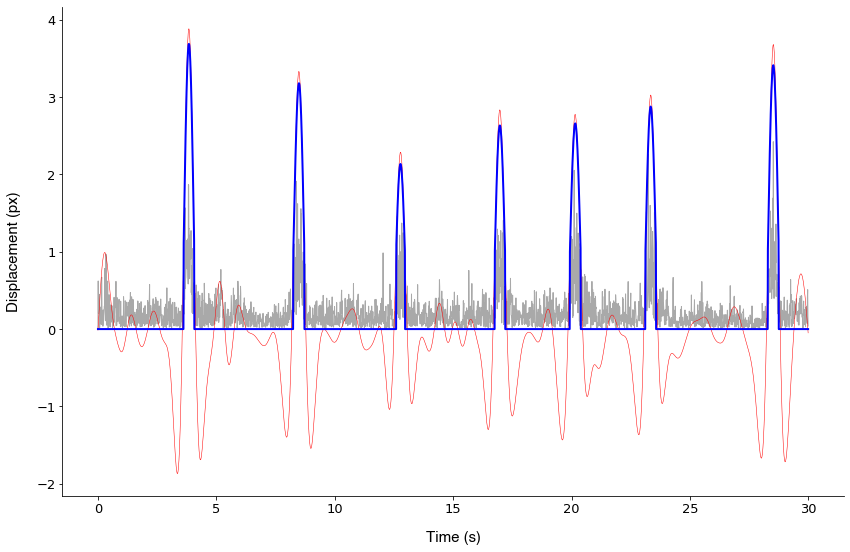

In [22]:
fish_distance = LC20[:,-1]
if np.sum(np.isnan(fish_distance)) > 0:
    np.nan_to_num(fish_distance,copy=False,nan=0)

t = np.arange(0, 3000, 1)
sig = fish_distance #composite signal
sig_clean = sig #copy for later comparison
minsignal, maxsignal = sig.min(), sig.max()

widths = np.arange(1, 3000)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
# fig, ax = plt.subplots(1,1,figsize=(18,10))
# ax.plot(cwtmatr[0,:])
# ax.plot(sig,'k',lw=1)
# ax.matshow(cwtmatr.real, extent=[1, 3000, 0, 6], cmap='seismic', aspect='auto',interpolation='nearest')
# plt.show()

t = np.arange(0, 3000, 1)
cwt_sig = cwtmatr[25,:] #composite signal
signal_clean = sig #copy for later comparison
minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(cwt_sig, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(1*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

## Filter out noise
threshold = 1
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

fft_signal = signal_filtered.real
fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

fish_distance_2 = []
for frame in fft_gauss:
    if frame<=1:
        frame=0
    fish_distance_2.append(frame)
fft_gauss = fish_distance_2

fig, ax = plt.subplots(1,1,figsize=(14,9))
ax.plot(sig,'darkgray',lw=1,label='Original data')
ax.plot(cwt_sig, 'red', lw=0.5, label='CWT transformed data')
ax.plot(fft_gauss, '-', color='b',lw=2,label='FFT transformed data with gaussian smoothing')
# ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
# ax.legend()
# ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]
x_labels = [0,5,10,15,20,25,30] 
plt.xticks(x_ticks, x_labels,fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Time (s)',size=15,name='Helvetica',labelpad=15)
plt.ylabel('Displacement (px)',size=15,name='Helvetica',labelpad=15)

plt.savefig('../../Dissertation/cwt_fft_transform.png',dpi=400,bbox_inches='tight')
plt.show()


peaks = find_peaks(fft_gauss,height=1)

# print('Number of Peaks: ',len(peaks[0]))

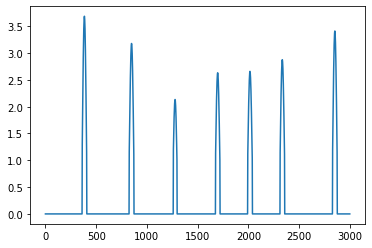

In [57]:
plt.plot(fft_gauss)

In [35]:
indices = []
for val in fft_gauss:
    if val == 0:
        indices.append(0)
    else:
        indices.append(fft_gauss.index(val))

In [36]:
pd.DataFrame(LC20)

,0,1,2,3,4,5
0,0.01,696.2269,177.9814,3.853382,0.00000,0.000000
1,0.02,696.6877,178.3990,3.897256,-0.04387,0.621873
2,0.03,696.5689,178.2321,3.899591,-0.04621,0.204863
3,0.04,696.6893,178.4439,3.895385,-0.04200,0.243630
4,0.05,696.5397,178.2434,3.897940,-0.04456,0.250161
...,...,...,...,...,...,...
2995,29.96,568.8122,324.2206,0.877651,2.97573,0.072202
2996,29.97,568.5107,323.9468,0.839622,3.01376,0.407270
2997,29.98,568.8712,324.3068,0.878171,2.97521,0.509471
2998,29.99,568.7502,324.1866,0.879058,2.97433,0.170555


In [37]:
df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])

In [38]:
df['ind'] = indices

In [39]:
df['init_cum'] = LC20[:,4]

In [40]:
df['init_dist'] = LC20[:,5]

In [41]:
df['event'] = 0

In [42]:
df

,fft_gauss,ind,init_cum,init_dist,event
0,0.0,0,0.00000,0.000000,0
1,0.0,0,-0.04387,0.621873,0
2,0.0,0,-0.04621,0.204863,0
3,0.0,0,-0.04200,0.243630,0
4,0.0,0,-0.04456,0.250161,0
...,...,...,...,...,...
2995,0.0,0,2.97573,0.072202,0
2996,0.0,0,3.01376,0.407270,0
2997,0.0,0,2.97521,0.509471,0
2998,0.0,0,2.97433,0.170555,0


In [37]:
# dont forget to clean events that start mid-beginning and mid-end of experiment (get rid of them)

In [38]:
# this is: 
#       for contrast in all_contrasts:
#           for fish in combined_fish:

In [43]:
counter = 1 
for index, row in df.iterrows():  
    if row['fft_gauss'] != 0:
        df.at[index,'event'] = counter
        if df.at[index+1,'fft_gauss'] == 0:
            counter += 1

In [44]:
event_df = pd.DataFrame(columns=['event','duration_s','delta_tetha_rad','distance','start_ind','end_ind','latency_s'])
event_df['event'] = df['event'].unique()[1:]

event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

event_df['delta_tetha_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                               for i, r in event_df.iterrows()]

event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                         for i, r in event_df.iterrows()]

# event_df['distance'] = ADD all frames per event except first one
event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                        ['init_dist'][0] for ev in df['event'].unique()[1:]]

# event_df = event_df.drop(columns=['start_ind','end_ind'])

In [45]:
event_df

,event,duration_s,delta_tetha_rad,distance,start_ind,end_ind,latency_s
0,1,0.45,0.29310,36.031956,362,406,NaN
1,2,0.47,0.37781,33.393291,825,871,4.19
2,3,0.37,0.09973,22.400544,1260,1296,3.89
3,4,0.44,0.19871,29.869284,1676,1719,3.80
4,5,0.46,0.19608,32.186442,1993,2038,2.74
5,6,0.45,0.21758,32.467395,2312,2356,2.74
6,7,0.46,0.54720,33.996767,2829,2874,4.73


In [46]:
event_df['duration_s'].mean()

0.4428571428571429

In [47]:
event_df['delta_tetha_rad'].mean()

0.27574428571428555

In [48]:
event_df['distance'].mean()

31.477954002966015

In [49]:
event_df['latency_s'].mean()

3.6816666666666666